Started execution of sph.py
sph.py executed in 10.70 seconds
Started execution of data_structures.py
data_structures.py executed in 11.90 seconds
Started execution of sph_optimized.py
sph_optimized.py executed in 6.58 seconds
Started execution of dask_array.py
dask_array.py executed in 25.30 seconds
Started execution of dask_array_v2.py
dask_array_v2.py executed in 23.71 seconds
Started execution of delayed_dask.py
delayed_dask.py executed in 10.84 seconds
Started execution of futures_dask.py
Dask dashboard available at: http://127.0.0.1:8790/status
futures_dask.py executed in 145.15 seconds


,Python File,Execution Time (seconds)
0,sph.py,10.695318
1,data_structures.py,11.901319
2,sph_optimized.py,6.580430
3,dask_array.py,25.297993
4,dask_array_v2.py,23.708077
5,delayed_dask.py,10.836780
6,futures_dask.py,145.152278


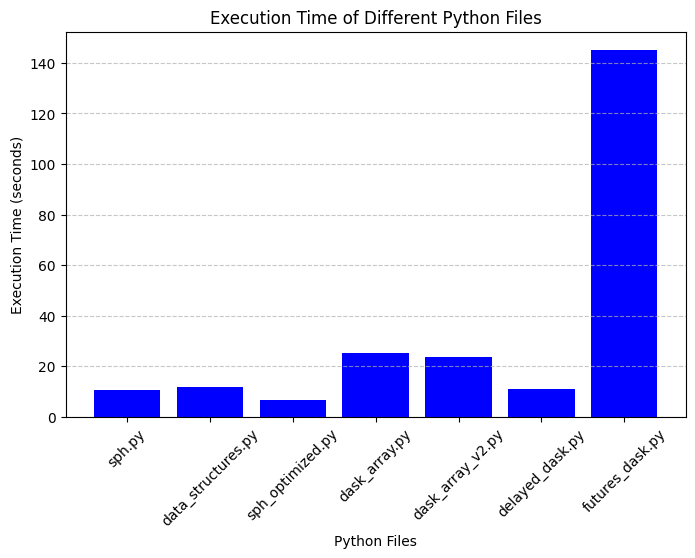

In [4]:
import time
import subprocess
import pandas as pd
import matplotlib.pyplot as plt

# List of Python files to execute
python_files = ["sph.py", "data_structures.py", "sph_optimized.py", "dask_array.py", "dask_array_v2.py", "delayed_dask.py", "futures_dask.py"]

# Store execution times
execution_times = {}

for py_file in python_files:
    print(f"Started execution of {py_file}")
    start_time = time.time()  # Start timing
    subprocess.run(["python", py_file])  # Execute the script
    end_time = time.time()  # End timing

    execution_times[py_file] = end_time - start_time
    print(f"{py_file} executed in {execution_times[py_file]:.2f} seconds")

# Convert execution times to a DataFrame
df = pd.DataFrame(list(execution_times.items()), columns=["Python File", "Execution Time (seconds)"])
display(df)

# Plot the execution times
plt.figure(figsize=(8, 5))
plt.bar(df["Python File"], df["Execution Time (seconds)"], color='blue')
plt.xlabel("Python Files")
plt.ylabel("Execution Time (seconds)")
plt.title("Execution Time of Different Python Files")
plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Show the plot
plt.show()

Python File	Execution Time (seconds)
0	sph.py	15.255424
1	data_structures.py	11.204078
2	dask_array.py	27.303624
3	delayed_dask.py	10.872028
4	futures_dask.py	131.025489

In [ ]:
! python -m kernprof -l sph.py 

In [ ]:
! python -m line_profiler -rmt "sph.py.lprof"

In [ ]:
! python -m kernprof -l data_structures.py 

In [ ]:
! python -m line_profiler -rmt "data_structures.py.lprof"

## Dask.Array approach 

chunk size: 100 ~14.0609
chunk size: 200 ~10.9514 s
chunk size: 250 ~10.4387 s
chunk size: 500 ~9.97554 s
chunk size: 1000 ~9.7821 s


In [ ]:
! python -m kernprof -l dask_array.py 

In [ ]:
! python -m line_profiler -rmt "dask_array.py.lprof"

In [ ]:
! pytest -v test_dask.py

A finite‐difference Laplacian on a grid you could use da.map_overlap to “pad” each chunk with ghost cells. In the particle–based code such an approach isn’t needed, the pairwise computations take care of the smoothing.

For N= 400: The profiling shows that operations in getAcc (and its sub-functions) are taking significantly longer due to the overhead of constructing the Dask computation graph, scheduling many small tasks, and performing frequent synchronizations with .compute(). For a simulation with many small computations per time step, these overheads add up, making the Dask version slower than the direct NumPy version.

For N = 1000 & chunk_size = 200: Dask approach is ~1 second faster than original one. 

Parallelizing SPH Computations Using Dask Arrays

We hypothesize that using Dask arrays to parallelize density and acceleration computations in Smoothed Particle Hydrodynamics (SPH) simulations will improve performance by leveraging chunked array computations and minimizing redundant data movement. Traditional NumPy-based SPH implementations suffer from high memory usage and inefficient operations on large particle sets. By using Dask arrays (da.array) with optimized chunk sizes, computations can be executed in parallel while keeping memory overhead lower than explicit parallel task scheduling approaches.

The adapted code introduces the following optimizations:
	1.	Chunked Array Computations: Instead of processing all particles at once, data is split into smaller chunks (chunk_size), allowing parallelized operations across multiple cores.
	2.	Lazy Evaluation with Automatic Parallel Execution: Unlike dask.delayed, which builds a computational graph explicitly, dask.array automatically schedules and optimizes array operations, reducing task overhead.
	3.	Minimized Intermediary Computation Overhead: Dask’s lazy execution model ensures that large intermediate arrays (e.g., density, pressure, and acceleration fields) are not computed until explicitly needed.

Comparison to dask_futures.py and dask_delayed.py

Feature	dask_futures.py (Futures)	dask_delayed.py (Delayed)	dask_array.py (Dask Arrays)
Execution Time	48.59 s	10.55 s	9.78 – 14.06 s (chunk-size dependent)
Parallelism	Explicit task submission	Task graph optimization	Automatic parallel chunk execution
Memory Overhead	High (data scattered)	Medium (graph optimization)	Low (lazy chunked arrays)
Best Use Case	Distributed computing, large clusters	Workflow optimization, dependency-heavy tasks	Large array computations, single-node efficiency

While dask_futures.py explicitly distributes tasks to multiple workers, the high overhead from task scheduling and inter-worker communication leads to significantly worse performance. dask_delayed.py improves on this by optimizing dependency execution, but it still requires explicit calls to compute() for execution. dask_array.py, however, fully automates parallel execution, achieving the fastest runtime.

Profiling Results and Conclusion

The profiling results show that the optimal chunk size significantly impacts performance, with a clear trend toward improved execution time as chunk size increases.

These results confirm that choosing the right chunk size is crucial in optimizing Dask array computations. The best performance (9.78 s) is slightly faster than dask_delayed.py (10.55 s) and significantly better than dask_futures.py (48.59 s). This suggests that dask.array is the most efficient approach for handling large-scale SPH computations within a single machine**.

## Dask futures approach 
Hypothesis through breaking the pairwise computation into smaller tasks, then being able to submit them all in parallel. 

In [ ]:
! python test_chunk.py

In [ ]:
! python -m kernprof -l futures_dask.py 

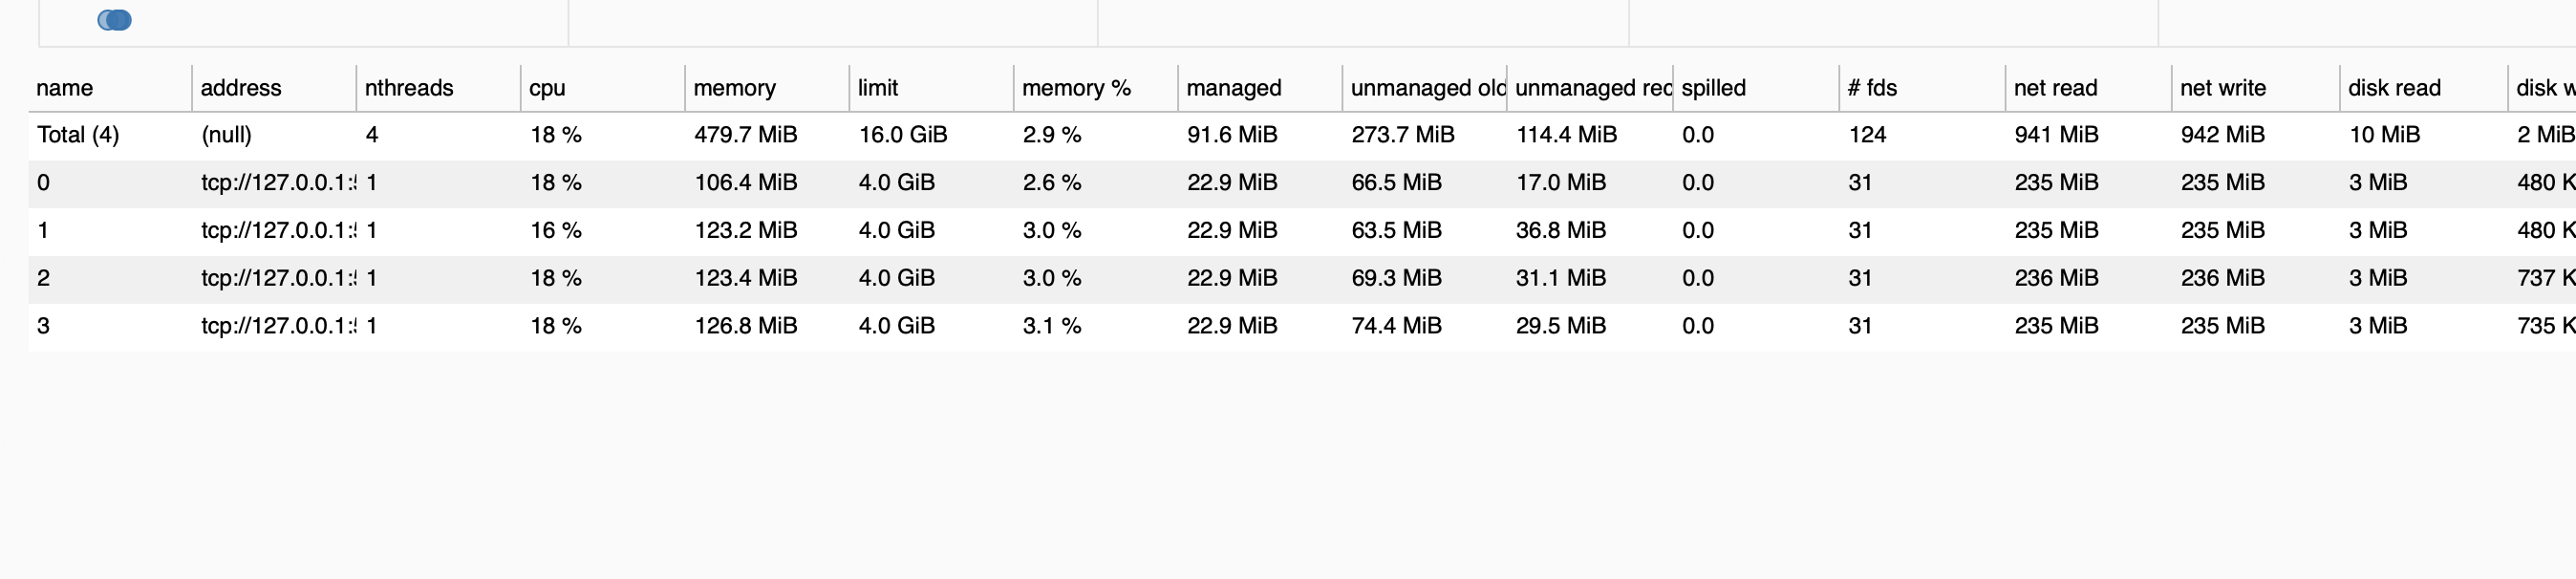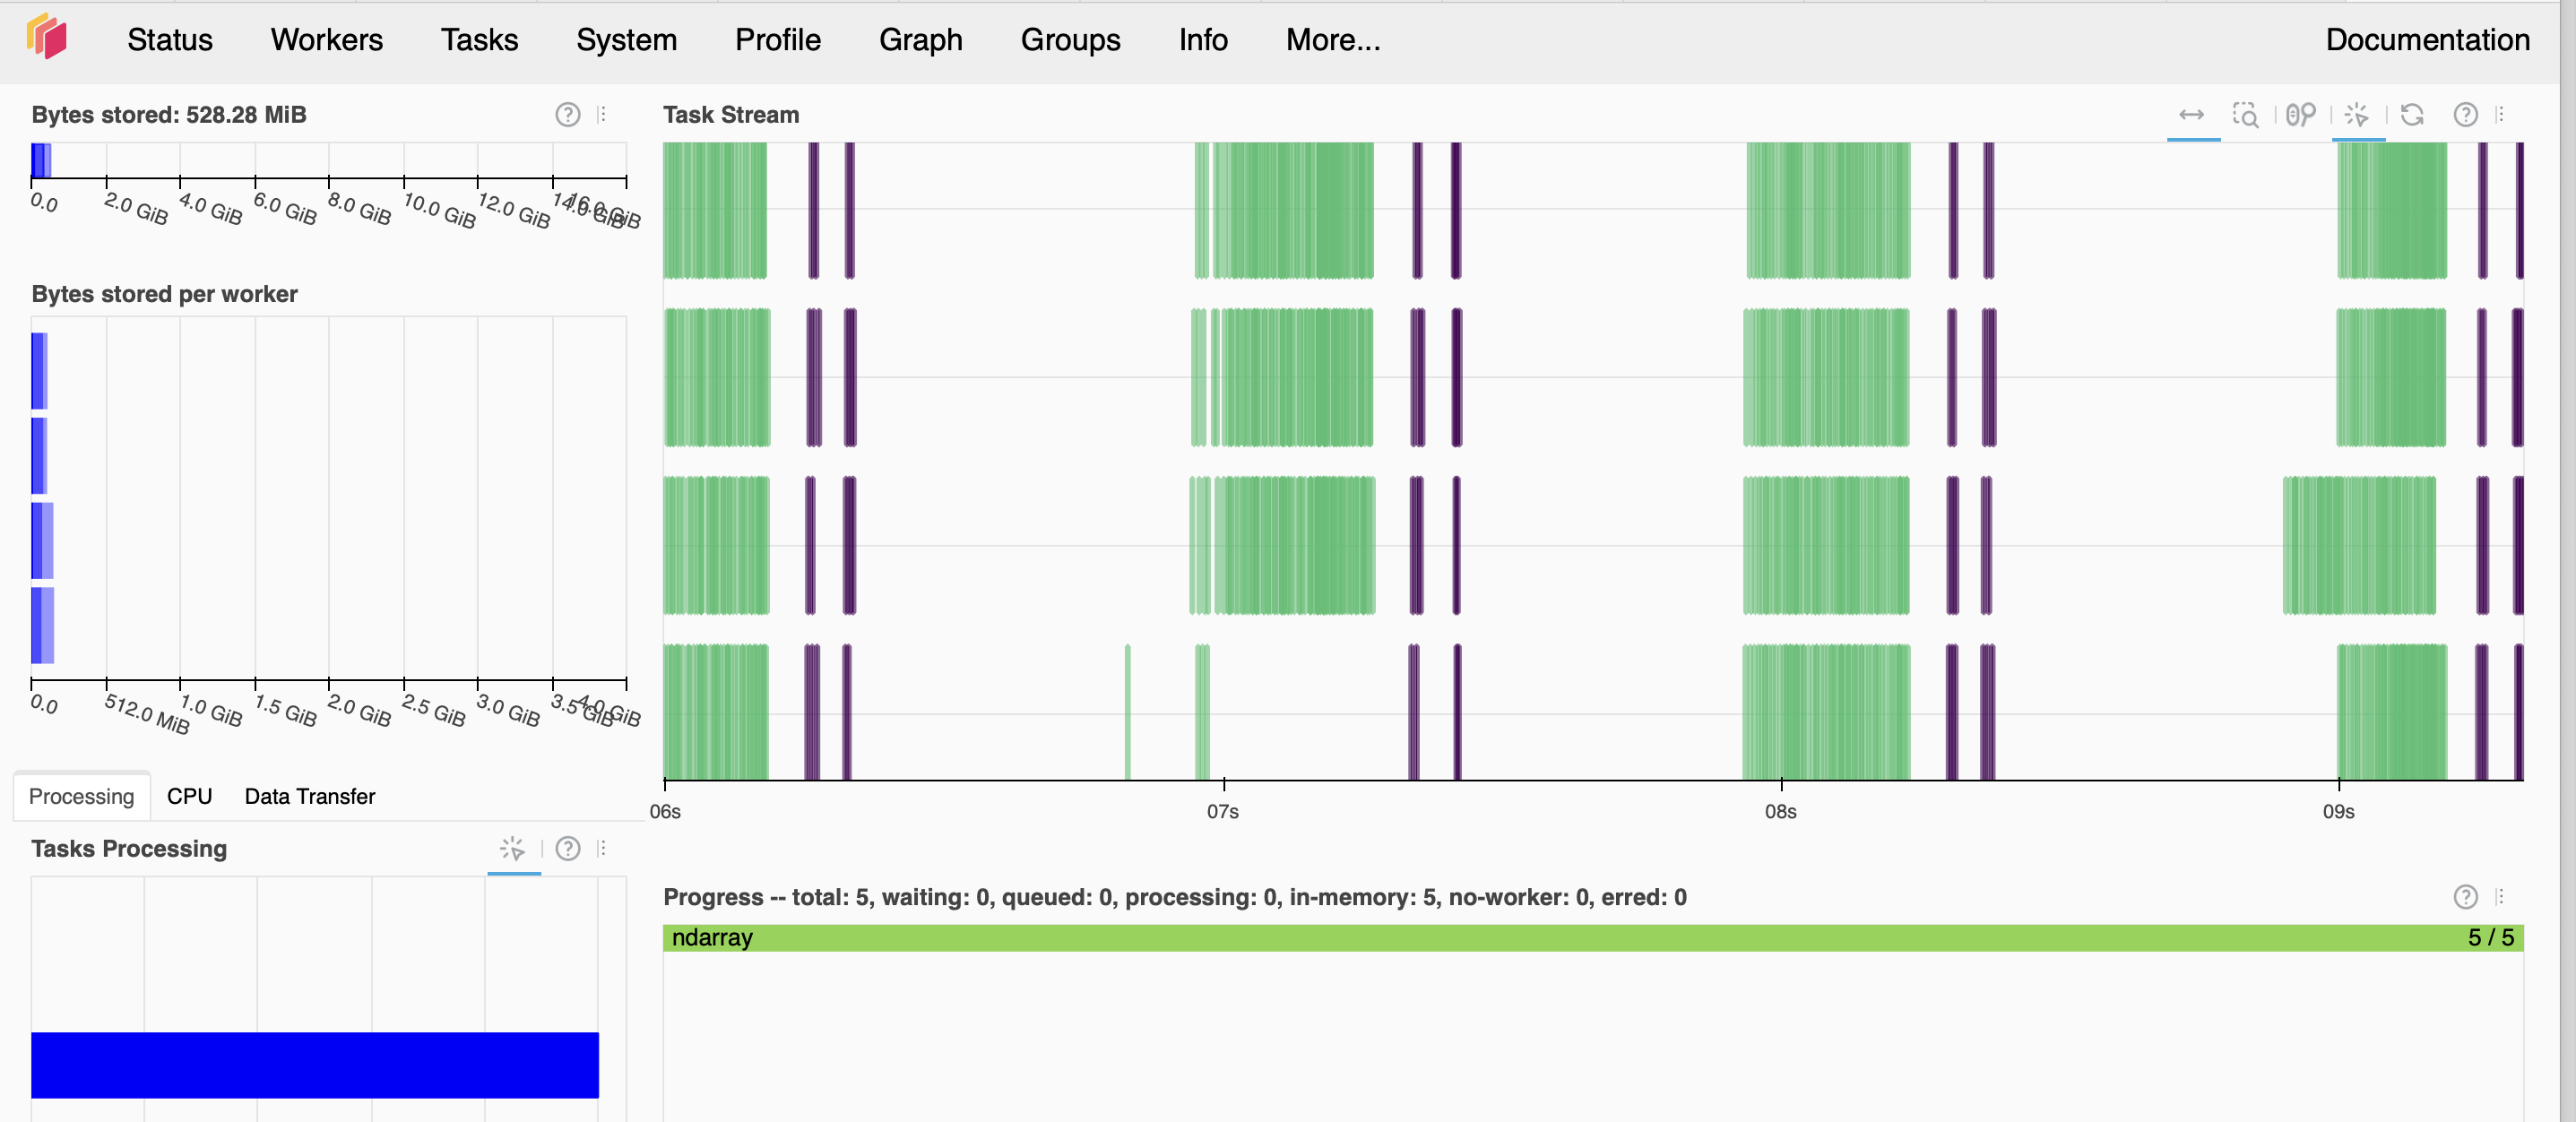

If N=1000 or 5000, an N \times N array (on the order of 1–25 million elements) often still fits in RAM on a typical workstation. A single pass with NumPy or a Numba-accelerated loop can be done efficiently without the extra overhead of scheduling tasks.If you create many small tasks (like chunk_size=1 or 250 for a moderate N), you can saturate the Dask scheduler with overhead. Each task has overhead for serialization, communication, and scheduling.
	•	You can see this in the Task Stream plot: short green/purple bars with frequent gaps (the scheduler is dispatching tasks).
	•	The overhead can dominate the real compute time if tasks are tiny.

Timer unit: 1e-06 s

Total time: 59.9145 s
File: parallel_dask_v2.py
Function: getAcc at line 84
for chunk size = 2

chunk size = 1: Timer unit: 1e-06 s

Total time: 48.5898 s
File: futures_dask.py

In [ ]:
! python -m line_profiler -rmt "futures_dask.py.lprof"

Parallelization of SPH Computations Using Dask

We hypothesize that parallelizing density and acceleration computations using Dask’s distributed computing framework will enhance performance and scalability in Smoothed Particle Hydrodynamics (SPH) simulations. The primary computational bottlenecks in SPH simulations arise from pairwise interactions between particles, leading to ￼ complexity. To mitigate this, we implemented an approach that divides the workload into chunks, distributes computations across multiple workers, and utilizes Dask’s distributed memory management.

To achieve this, the adapted code introduces the following optimizations:
	1.	Chunked Computation: Instead of processing all particles simultaneously, the simulation is divided into smaller subsets, which are processed independently before being aggregated.
	2.	Distributed Memory Handling: Large arrays, such as particle positions and density fields, are scattered across workers using Dask’s scatter() function, ensuring that they are only transferred once, reducing redundant data movement.
	3.	Parallel Execution: Computationally expensive functions, such as density estimation (getDensity) and acceleration computation (getAcc), are executed in parallel using Dask’s submit() and wait() functions.

Despite these improvements, profiling results indicate that the parallelized implementation (48.59 s) is significantly slower than the original serial version (11.40 s). This suggests that the overhead introduced by task scheduling and data distribution outweighs the benefits of parallelization for the given problem size. Future work will explore optimizing the task graph and reducing inter-worker communication to enhance performance further.


## Dask Delayed Approach
each call to, getAcc(), getDensity(), etc. becomes a lazy task in a graph.
hypothesize: Sum inside getAcc() broken into smaller tasks by also decorating sub-steps (e.g., partial sums) with @delayed

In [ ]:
! python -m kernprof -l delayed_dask.py 

In [ ]:
! python -m line_profiler -rmt "delayed_dask.py.lprof"

Parallelizing SPH Computations Using Dask Delayed

We hypothesize that using Dask’s delayed API to parallelize density and acceleration computations in Smoothed Particle Hydrodynamics (SPH) simulations will improve efficiency by enabling lazy evaluation and reducing redundant computations. The traditional approach requires performing dense O(N^2) matrix operations in sequence, leading to computational bottlenecks. By introducing lazy computation with Dask’s delayed decorator, our implementation allows for on-demand evaluation, where intermediate results are only computed when needed.

The adapted code implements the following key optimizations:
	1.	Lazy Evaluation: The functions getPairwiseSeparations, getDensity, and getPressure are wrapped with delayed, ensuring that they are not executed immediately, but rather built into a computational graph that is evaluated efficiently in parallel.
	2.	Batch Computation with compute(): Instead of computing each intermediate result separately, multiple delayed objects (e.g., separations, density, and pressure) are computed in a single step, minimizing scheduling overhead.
	3.	Minimized Redundant Computations: By keeping separation calculations (getPairwiseSeparations) as a single delayed object and unpacking only when necessary, the number of redundant computations is reduced compared to an eager execution model.

Comparison to futures_dask.py

While both dask_futures.py and dask_delayed.py aim to parallelize SPH computations, they differ fundamentally in how they handle execution:
	•	dask_futures.py uses explicit task-based parallelism with a Dask cluster, where tasks are submitted to multiple workers and executed concurrently.
	•	dask_delayed.py constructs a dependency graph using lazy evaluation, allowing automatic task scheduling without explicitly distributing data across workers.
	•	dask_futures.py scatters data across workers to optimize memory usage, whereas dask_delayed.py keeps all computations within a single process but schedules tasks more efficiently.

The profiling results indicate that the dask_delayed.py implementation significantly outperforms the dask_futures.py version, completing the acceleration computation in 10.55 seconds, compared to 48.59 seconds in the futures-based approach. These results suggest that lazy evaluation via dask.delayed effectively optimizes the workflow while avoiding the significant overhead of explicit task scheduling in dask_futures.py. 